# CRAIG-only
(created on 12/13/2024)

The CRAIG data selection algorithm is implemented using the CORDS library.

--------------------------------------------
Link to CORDS: https://cords.readthedocs.io/en/latest/

## 1. Install and import libraries
Follow these steps to install and import **CORDS** and **Submodlib**.


### Cloning CORDS repository

In [ ]:
!git clone https://github.com/decile-team/cords.git
%cd cords/
%ls

Cloning into 'cords'...
remote: Enumerating objects: 5172, done.
remote: Counting objects: 100% (487/487), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 5172 (delta 357), reused 464 (delta 352), pack-reused 4685 (from 1)
Receiving objects: 100% (5172/5172), 58.85 MiB | 21.53 MiB/s, done.
Resolving deltas: 100% (3209/3209), done.
/content/cords
benchmarks/   cords/     gradio_hpo.py  README.md      tests/        train_ssl.py
CITATION.CFF  docs/      gradio_sl.py   requirements/  train_hpo.py  transformers_train_sl.py
configs/      examples/  LICENSE.txt    setup.py       train_sl.py   tutorial/


### Install prerequisite libraries of CORDS

In [ ]:
!pip install dotmap
!pip install apricot-select
!pip install ray[default]
!pip install ray[tune]
!pip install datasets
!pip install transformers
!pip install sentence-transformers
!pip install scikit-learn
!pip install wandb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for apricot-select: filename=apricot_select-0.6.1-py3-none-any.whl size=48766 sha256=176e6c82169ceda9df5c39558315db0206a996211d6dda2d5277479ad2a8394b
  Stored in directory: /root/.cache/pip/wheels/df/d8/f9/4d62b7272bff772a126a52e507212c2fd33c0b8416d9389665
Successfully built apricot-select
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

### Install Submodlib

In [ ]:
%cd ..
!git clone https://github.com/decile-team/submodlib.git
%cd submodlib
!pip install .
%cd ../cords

/content
Cloning into 'submodlib'...
remote: Enumerating objects: 2583, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 2583 (delta 8), reused 14 (delta 4), pack-reused 2559 (from 1)
Receiving objects: 100% (2583/2583), 30.58 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (1917/1917), done.
/content/submodlib
Processing /content/submodlib
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for submodlib: filename=submodlib-1.1.5-cp310-cp310-linux_x86_64.whl size=577257 sha256=ba89295a20ff876f8f14581471b5257772851703c05e00af9beba482abf08d34
  Stored in directory: /tmp/pip-ephem-wheel-cache-zo66xja1/wheels/38/8a/82/dcc1be631ad42bd42b29737e6f518581c869e8a7e861adfba8
Successfully built submodlib
/content/cords


### Import necessary libraries

In [ ]:
import time
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from cords.utils.data.datasets.SL import gen_dataset
from torch.utils.data import Subset
from cords.utils.config_utils import load_config_data
import os.path as osp
from cords.utils.data.data_utils import WeightedSubset
from ray import tune

## 2. Data, model, and utility functions preparaion
- Use the preprocessed MNIST dataset from the CORDS library. Divide the dataset into training and validation sets with a 90%-10% split.
- Models ResNet18 and 2-layer CNN varied in this experiment are available in the CORDS library. These models require wrapper methods for subset selection later.

### Loading the MNIST dataset




In [ ]:
trainset, validset, testset, num_cls = gen_dataset('data/', 'mnist', None, isnumpy=False)

### Create Train, Validation and Test dataloaders

In [ ]:
trn_batch_size = 128
val_batch_size = 128
tst_batch_size = 1000

# Creating the Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=trn_batch_size,
                                          shuffle=False, pin_memory=True)

valloader = torch.utils.data.DataLoader(validset, batch_size=val_batch_size,
                                        shuffle=False, pin_memory=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=tst_batch_size,
                                          shuffle=False, pin_memory=True)


### Defining Model

CORDS has a set of predefined models bulit in utils folder. You can import them directly.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from cords.utils.models import ResNet18
# numclasses = 10
# model = ResNet18(10)
# model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
# model.maxpool = nn.Identity()
# model = model.to(device)

from cords.utils.models import CNN
model = CNN(10)
model = model.to(device)

### Defining Loss Functions

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion_nored = nn.CrossEntropyLoss(reduction='none')

### Checkpoint Utility functions

In [ ]:
def save_ckpt(state, ckpt_path):
    torch.save(state, ckpt_path)


def load_ckpt(ckpt_path, model, optimizer):
    checkpoint = torch.load(ckpt_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    metrics = checkpoint['metrics']
    return start_epoch, model, optimizer, loss, metrics


### Cumulative time calculation

In [ ]:
def generate_cumulative_timing(mod_timing):
    tmp = 0
    mod_cum_timing = np.zeros(len(mod_timing))
    for i in range(len(mod_timing)):
        tmp += mod_timing[i]
        mod_cum_timing[i] = tmp
    return mod_cum_timing


### Defining Optimizers and schedulers

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=5e-2,
                                  momentum=0.9,
                                  weight_decay=5e-4,
                                  nesterov=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=200)


### Get logger object for logging

In [ ]:
def __get_logger(results_dir):
  os.makedirs(results_dir, exist_ok=True)
  # setup logger
  plain_formatter = logging.Formatter("[%(asctime)s] %(name)s %(levelname)s: %(message)s",
                                      datefmt="%m/%d %H:%M:%S")
  logger = logging.getLogger(__name__)
  logger.setLevel(logging.INFO)
  s_handler = logging.StreamHandler(stream=sys.stdout)
  s_handler.setFormatter(plain_formatter)
  s_handler.setLevel(logging.INFO)
  logger.addHandler(s_handler)
  f_handler = logging.FileHandler(os.path.join(results_dir, "results.log"))
  f_handler.setFormatter(plain_formatter)
  f_handler.setLevel(logging.INFO)
  logger.addHandler(f_handler)
  logger.propagate = False
  return logger



### Instantiating logger file for logging the information

In [ ]:
import logging
import os
import os.path as osp
import sys

#Results logging directory
results_dir = osp.abspath(osp.expanduser('results'))
logger = __get_logger(results_dir)

## 3. Instantiate CRAIG coreset selection
We instantiate subset dataloaders that can be used for training the models with adaptive subsets. It needs argument in the form of a dotmap dictionary, logger and dataloader with specific arguments like batch size, shuffle etc.

In [ ]:
from cords.utils.data.dataloader.SL.adaptive import CRAIGDataLoader
from dotmap import DotMap

selection_strategy = 'CRAIG'
dss_args = dict(model=model,
                loss=criterion_nored,
                eta=0.01,
                num_classes=10,
                num_epochs=100,
                device='cuda',
                type="CRAIG",
                fraction=0.6,
                select_every=20,
                lam=0.5,
                selection_type='PerClass',
                v1=True,
                valid=False,
                kappa=0,
                eps=1e-100,
                linear_layer=True,
                optimizer='lazy',
                if_convex=False)
dss_args = DotMap(dss_args)

dataloader = CRAIGDataLoader(trainloader, valloader, dss_args, logger,
                                  batch_size=20,
                                  shuffle=True,
                                  pin_memory=False)



[12/14 00:41:52] __main__ INFO: CRAIG dataloader initialized. 
[12/14 00:41:52] __main__ INFO: CRAIG dataloader initialized. 


### Additional arguments for training, evaluation and checkpointing

In [ ]:
#Training Arguments
num_epochs = 50

#Arguments for results logging
print_every = 5
print_args = ["val_loss", "val_acc", "tst_loss", "tst_acc", "trn_loss", "trn_acc", "time"]

#Argumets for checkpointing
save_every = 1
is_save = True

#Evaluation Metrics
trn_losses = list()
val_losses = list()
tst_losses = list()
subtrn_losses = list()
timing = [0]
trn_acc = list()
best_acc = list()
curr_best_acc = 0
val_acc = list()
tst_acc = list()
subtrn_acc = list()


## 4. Evaluation Function

In [ ]:
def evaluate_model(curr_best_acc):
    """
    ################################################# Evaluation Loop #################################################
    """
    trn_loss = 0
    trn_correct = 0
    trn_total = 0
    val_loss = 0
    val_correct = 0
    val_total = 0
    tst_correct = 0
    tst_total = 0
    tst_loss = 0
    model.eval()
    logger_dict = {}
    if ("trn_loss" in print_args) or ("trn_acc" in print_args):
        samples=0

        with torch.no_grad():
            for _, data in enumerate(trainloader):
                inputs, targets = data

                inputs, targets = inputs.to(device), \
                                  targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                trn_loss += (loss.item() * trainloader.batch_size)
                samples += targets.shape[0]
                if "trn_acc" in print_args:
                    _, predicted = outputs.max(1)
                    trn_total += targets.size(0)
                    trn_correct += predicted.eq(targets).sum().item()
            trn_loss = trn_loss/samples
            trn_losses.append(trn_loss)
            logger_dict['trn_loss'] = trn_loss
        if "trn_acc" in print_args:
            trn_acc.append(trn_correct / trn_total)
            logger_dict['trn_acc'] = trn_correct / trn_total

    if ("val_loss" in print_args) or ("val_acc" in print_args):
        samples =0
        with torch.no_grad():
            for _, data in enumerate(valloader):
                inputs, targets = data
                inputs, targets = inputs.to(device), \
                                  targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += (loss.item() * valloader.batch_size)
                samples += targets.shape[0]
                if "val_acc" in print_args:

                    _, predicted = outputs.max(1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()
            val_loss = val_loss/samples
            val_losses.append(val_loss)
            logger_dict['val_loss'] = val_loss

        if "val_acc" in print_args:
            val_acc.append(val_correct / val_total)
            logger_dict['val_acc'] = val_correct / val_total

    if ("tst_loss" in print_args) or ("tst_acc" in print_args):
        samples =0
        with torch.no_grad():
            for _, data in enumerate(testloader):
                inputs, targets = data

                inputs, targets = inputs.to(device), \
                                  targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                tst_loss += (loss.item() * testloader.batch_size)
                samples += targets.shape[0]
                if "tst_acc" in print_args:
                    _, predicted = outputs.max(1)
                    tst_total += targets.size(0)
                    tst_correct += predicted.eq(targets).sum().item()
            tst_loss = tst_loss/samples
            tst_losses.append(tst_loss)
            logger_dict['tst_loss'] = tst_loss

        if (tst_correct/tst_total) > curr_best_acc:
            curr_best_acc = (tst_correct/tst_total)

        if "tst_acc" in print_args:
            tst_acc.append(tst_correct / tst_total)
            best_acc.append(curr_best_acc)
            logger_dict['tst_acc'] = tst_correct / tst_total
            logger_dict['best_acc'] = curr_best_acc

    if "subtrn_acc" in print_args:
        if epoch == 0:
            subtrn_acc.append(0)
            logger_dict['subtrn_acc'] = 0
        else:
            subtrn_acc.append(subtrn_correct / subtrn_total)
            logger_dict['subtrn_acc'] = subtrn_correct / subtrn_total

    if "subtrn_losses" in print_args:
        if epoch == 0:
            subtrn_losses.append(0)
            logger_dict['subtrn_loss'] = 0
        else:
            subtrn_losses.append(subtrn_loss)
            logger_dict['subtrn_loss'] = subtrn_loss

    print_str = "Epoch: " + str(epoch)
    logger_dict['Epoch'] = epoch
    logger_dict['Time'] = train_time

    """
    ################################################# Results Printing #################################################
    """

    for arg in print_args:
        if arg == "val_loss":
            print_str += " , " + "Validation Loss: " + str(val_losses[-1])

        if arg == "val_acc":
            print_str += " , " + "Validation Accuracy: " + str(val_acc[-1])

        if arg == "tst_loss":
            print_str += " , " + "Test Loss: " + str(tst_losses[-1])

        if arg == "tst_acc":
            print_str += " , " + "Test Accuracy: " + str(tst_acc[-1])
            print_str += " , " + "Best Accuracy: " + str(best_acc[-1])

        if arg == "trn_loss":
            print_str += " , " + "Training Loss: " + str(trn_losses[-1])

        if arg == "trn_acc":
            print_str += " , " + "Training Accuracy: " + str(trn_acc[-1])

        if arg == "subtrn_loss":
            print_str += " , " + "Subset Loss: " + str(subtrn_losses[-1])

        if arg == "subtrn_acc":
            print_str += " , " + "Subset Accuracy: " + str(subtrn_acc[-1])

        if arg == "time":
            print_str += " , " + "Timing: " + str(timing[-1])

    logger.info(print_str)


## 5. Training loop with evaluation

Subset dataloader returns data samples, labels and associated weights with each data sample. Hence, inorder to incorporate the weights in the dataloader into the training loop, we use a **loss function**  with **reduction='none'** to get per-sample loss values. Then we calculate the weighted average of batch losses using the following code snippet:

`loss = torch.dot(losses, weights/(weights.sum()))`

In [ ]:
"""
################################################# Training Loop #################################################
"""
train_time = 0
for epoch in range(0, num_epochs+1):

    # Evaluating the Model at Regular Intervals
    if (epoch % print_every == 0) or (epoch == num_epochs) or (epoch == 0):
        evaluate_model(curr_best_acc)

    subtrn_loss = 0
    subtrn_correct = 0
    subtrn_total = 0
    model.train()
    start_time = time.time()

    """
    ################################################# Mini-batch SGD #################################################
    """
    for _, (inputs, targets, weights) in enumerate(dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device, non_blocking=True)
        weights = weights.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        losses = criterion_nored(outputs, targets)
        loss = torch.dot(losses, weights / (weights.sum()))
        loss.backward()
        subtrn_loss += loss.item()
        optimizer.step()
        _, predicted = outputs.max(1)
        subtrn_total += targets.size(0)
        subtrn_correct += predicted.eq(targets).sum().item()
    epoch_time = time.time() - start_time
    scheduler.step()
    timing.append(epoch_time)
    train_time += epoch_time


    """
    ################################################# Checkpoint Saving #################################################
    """

    if ((epoch + 1) % save_every == 0):

        metric_dict = {}

        for arg in print_args:
            if arg == "val_loss":
                metric_dict['val_loss'] = val_losses
            if arg == "val_acc":
                metric_dict['val_acc'] = val_acc
            if arg == "tst_loss":
                metric_dict['tst_loss'] = tst_losses
            if arg == "tst_acc":
                metric_dict['tst_acc'] = tst_acc
                metric_dict['best_acc'] = best_acc
            if arg == "trn_loss":
                metric_dict['trn_loss'] = trn_losses
            if arg == "trn_acc":
                metric_dict['trn_acc'] = trn_acc
            if arg == "subtrn_loss":
                metric_dict['subtrn_loss'] = subtrn_losses
            if arg == "subtrn_acc":
                metric_dict['subtrn_acc'] = subtrn_acc
            if arg == "time":
                metric_dict['time'] = timing

        ckpt_state = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'metrics': metric_dict
        }

        # save checkpoint
        save_ckpt(ckpt_state, 'model.pth')
        logger.info("Model checkpoint saved at epoch: {0:d}".format(epoch + 1))

[12/14 00:42:12] __main__ INFO: Epoch: 0 , Validation Loss: 2.4214505462646483 , Validation Accuracy: 0.0855 , Test Loss: 2.4265477418899537 , Test Accuracy: 0.0877 , Best Accuracy: 0.0877 , Training Loss: 2.419684696903935 , Training Accuracy: 0.08331481481481481 , Timing: 0
[12/14 00:42:12] __main__ INFO: Epoch: 0 , Validation Loss: 2.4214505462646483 , Validation Accuracy: 0.0855 , Test Loss: 2.4265477418899537 , Test Accuracy: 0.0877 , Best Accuracy: 0.0877 , Training Loss: 2.419684696903935 , Training Accuracy: 0.08331481481481481 , Timing: 0
[12/14 00:42:23] __main__ INFO: Model checkpoint saved at epoch: 1
[12/14 00:42:23] __main__ INFO: Model checkpoint saved at epoch: 1
[12/14 00:42:34] __main__ INFO: Model checkpoint saved at epoch: 2
[12/14 00:42:34] __main__ INFO: Model checkpoint saved at epoch: 2
[12/14 00:42:45] __main__ INFO: Model checkpoint saved at epoch: 3
[12/14 00:42:45] __main__ INFO: Model checkpoint saved at epoch: 3
[12/14 00:42:56] __main__ INFO: Model checkp

KeyboardInterrupt: 

## 6. Results Summary Logging

In [ ]:
"""
################################################# Results Summary #################################################
"""
original_idxs = set([x for x in range(len(trainset))])
encountered_idxs = []
# if self.cfg.dss_args.type != 'Full':
for key in dataloader.selected_idxs.keys():
    encountered_idxs.extend(dataloader.selected_idxs[key])
encountered_idxs = set(encountered_idxs)
rem_idxs = original_idxs.difference(encountered_idxs)
encountered_percentage = len(encountered_idxs)/len(original_idxs)

logger.info("Selected Indices: ")
logger.info(dataloader.selected_idxs)
logger.info("Percentages of data samples encountered during training: %.2f", encountered_percentage)
logger.info("Not Selected Indices: ")
logger.info(rem_idxs)
logger.info("CRAIG Selection Run---------------------------------")
logger.info("Final SubsetTrn: {0:f}".format(subtrn_loss))
if "val_loss" in print_args:
    if "val_acc" in print_args:
        logger.info("Validation Loss: %.2f , Validation Accuracy: %.2f", val_losses[-1], val_acc[-1])
    else:
        logger.info("Validation Loss: %.2f", val_losses[-1])

if "tst_loss" in print_args:
    if "tst_acc" in print_args:
        logger.info("Test Loss: %.2f, Test Accuracy: %.2f, Best Accuracy: %.2f", tst_losses[-1], tst_acc[-1], best_acc[-1])
    else:
        logger.info("Test Data Loss: %f", tst_losses[-1])
logger.info('---------------------------------------------------------------------')
logger.info("CRAIG")
logger.info('---------------------------------------------------------------------')

"""
################################################# Final Results Logging #################################################
"""

if "val_acc" in print_args:
    val_str = "Validation Accuracy: "
    for val in val_acc:
        if val_str == "Validation Accuracy: ":
            val_str = val_str + str(val)
        else:
            val_str = val_str + " , " + str(val)
    logger.info(val_str)

if "tst_acc" in print_args:
    tst_str = "Test Accuracy: "
    for tst in tst_acc:
        if tst_str == "Test Accuracy: ":
            tst_str = tst_str + str(tst)
        else:
            tst_str = tst_str + " , " + str(tst)
    logger.info(tst_str)

    tst_str = "Best Accuracy: "
    for tst in best_acc:
        if tst_str == "Best Accuracy: ":
            tst_str = tst_str + str(tst)
        else:
            tst_str = tst_str + " , " + str(tst)
    logger.info(tst_str)

if "time" in print_args:
    time_str = "Time: "
    for t in timing:
        if time_str == "Time: ":
            time_str = time_str + str(t)
        else:
            time_str = time_str + " , " + str(t)
    logger.info(time_str)

omp_timing = np.array(timing)
omp_cum_timing = list(generate_cumulative_timing(omp_timing))
logger.info("Total time taken by %s = %.4f ", "CRAIG", omp_cum_timing[-1])

[12/14 00:12:23] __main__ INFO: Selected Indices: 
[12/14 00:12:23] __main__ INFO: {0: array([36253, 23506,  8565, ..., 26943, 48472, 51089]), 1: [46069, 53510, 31259, 40782, 21623, 29343, 46647, 32171, 40240, 19989, 12233, 8451, 15796, 36480, 52950, 46908, 32488, 29902, 43565, 15626, 27356, 12612, 24053, 15924, 1081, 2665, 53785, 42626, 33760, 25924, 5953, 34679, 38153, 34802, 16519, 24554, 36494, 48826, 23666, 49208, 46920, 41062, 37436, 11154, 20092, 43363, 4560, 23606, 10823, 17387, 44836, 38147, 1566, 39968, 3639, 26319, 52066, 15098, 18854, 46581, 33255, 42213, 34155, 9790, 51578, 29650, 17103, 930, 34239, 10073, 20515, 366, 30583, 46036, 10972, 14045, 30055, 4116, 35271, 38196, 13859, 6707, 46921, 42651, 385, 41642, 21650, 3961, 21361, 50466, 38289, 25035, 39626, 48293, 12886, 34003, 21594, 46523, 9774, 18971, 17508, 39533, 22690, 16498, 31578, 35203, 31511, 22930, 16015, 39020, 5990, 20478, 44381, 15751, 40561, 23, 27060, 44880, 11327, 44157, 28752, 50614, 53002, 20542, 22971, 

## 7. Visualize and export outputs

In [ ]:
import json
with open(f"/content/drive/MyDrive/260/Logs/metric_CRAIGonly_e{num_epochs}_f0.6_cnn.json", "w") as file:
    json.dump(metric_dict, file)

selected = list(encountered_idxs)
with open(f"/content/drive/MyDrive/260/Selected/CRAIGonly_f0.6_cnn.txt", "w") as file:
  for i in selected:
    file.write(f"{i},")

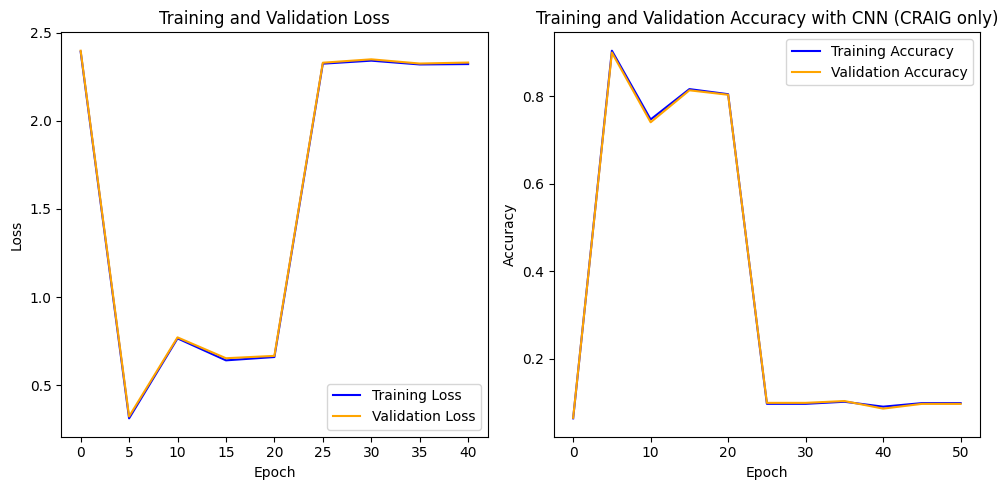

In [ ]:
import matplotlib.pyplot as plt

# Assuming trn_losses_craig, val_losses_craig, tst_losses_craig, trn_acc_craig, val_acc_craig, tst_acc_craig
# are lists containing the respective metrics for each epoch.

# Plot training and validation losses
plt.figure(figsize=(10, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(0, len(trn_losses)*5, 5), trn_losses, label="Training Loss", color="blue")
plt.plot(range(0,len(val_losses)*5, 5), val_losses, label="Validation Loss", color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(0, len(trn_acc)*5, 5), trn_acc, label="Training Accuracy", color="blue")
plt.plot(range(0, len(val_acc)*5, 5), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with CNN (CRAIG only)')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(f"/content/drive/MyDrive/260/Plots/metric_CRAIGonly_e{num_epochs}_f0.6_cnn.png")
plt.show()